# rozpoznawanie typów zgłoszeń klienta

In [1]:
import re
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics

import fastText

## data import

In [2]:
# read data from xls
dane_surowe=pd.read_excel('reklamacje.xlsx')

In [3]:
dane_surowe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26999 entries, 0 to 26998
Data columns (total 6 columns):
ID                  26835 non-null float64
data_przekazania    26835 non-null datetime64[ns]
nr_zgl_crm          26919 non-null float64
status_id           26835 non-null float64
tresc_zgl           26982 non-null object
typ_train           26999 non-null object
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 1.2+ MB


In [4]:
dane_surowe.head()

,ID,data_przekazania,nr_zgl_crm,status_id,tresc_zgl,typ_train
0,12.0,2018-07-27 09:01:23,21265444.0,0.0,Uzupełnij wykropkowane miejsca: 1)\treklama...,FNO
1,178.0,2018-07-27 12:01:23,21266238.0,0.0,Skarga na pracownika orange. W poniedziałek kl...,XSP
2,796.0,2018-07-28 12:00:55,21269757.0,0.0,Na życzenie klientki. W imieniu Pani Anny wyst...,OSA
3,834.0,2018-07-28 13:03:58,21269943.0,0.0,Doradca w czasie rozmowy z kl się rozłączył. W...,XSP
4,1072.0,2018-07-29 11:10:09,21271695.0,0.0,Klient zglasza skarge na doradce Łukasz Łukasz...,OSA


In [5]:
dane_surowe.describe()

,ID,nr_zgl_crm,status_id
count,26835.000000,2.691900e+04,26835.000000
mean,49775.503335,6.075148e+08,0.999553
std,8502.605378,7.363859e+08,0.021142
min,12.000000,2.126544e+07,0.000000
25%,42738.500000,2.152511e+07,1.000000
50%,49883.000000,2.158816e+07,1.000000
75%,56992.500000,1.532628e+09,1.000000
max,64066.000000,1.533747e+09,1.000000


In [6]:
input_data=pd.DataFrame()
input_data[['content','category']]=dane_surowe[['tresc_zgl','typ_train']]

In [7]:
input_data.head()

,content,category
0,Uzupełnij wykropkowane miejsca: 1)\treklama...,FNO
1,Skarga na pracownika orange. W poniedziałek kl...,XSP
2,Na życzenie klientki. W imieniu Pani Anny wyst...,OSA
3,Doradca w czasie rozmowy z kl się rozłączył. W...,XSP
4,Klient zglasza skarge na doradce Łukasz Łukasz...,OSA


In [8]:
# find duplicates
input_data[input_data.duplicated(keep=False)]

,content,category
252,Klient zgłasza reklamację z tytułu braku zasię...,VOI
255,Klient zgłasza reklamację z tytułu braku zasię...,VOI
278,Uzupełnij wykropkowane miejsca: 1)\treklama...,UPU
1302,2018.08.19 00:13\t+48 514 313 325\t22:12min:se...,FNO
1307,2018.08.19 00:13\t+48 514 313 325\t22:12min:se...,FNO
1396,"Pozdrawiam Marcin Migdalski Salon Orange, ...",AKO
1455,Dokument bez tytułu GTI Sp.z o.o. salon Pa...,FNO
1456,Dokument bez tytułu GTI Sp.z o.o. salon Pa...,FNO
1472,Dokument bez tytułu GTI Sp.z o.o. salon Pa...,AKO
1473,Dokument bez tytułu GTI Sp.z o.o. salon Pa...,AKO


In [9]:
# clearing data
# remove duplicates
input_data.drop_duplicates(inplace=True)
# remove empty
input_data=input_data.dropna()

In [10]:
input_data.head()

,content,category
0,Uzupełnij wykropkowane miejsca: 1)\treklama...,FNO
1,Skarga na pracownika orange. W poniedziałek kl...,XSP
2,Na życzenie klientki. W imieniu Pani Anny wyst...,OSA
3,Doradca w czasie rozmowy z kl się rozłączył. W...,XSP
4,Klient zglasza skarge na doradce Łukasz Łukasz...,OSA


## data analysis

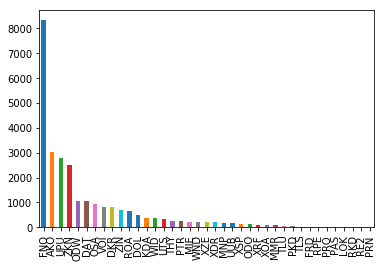

In [11]:
# statystyka częstotliwości kategorii
input_data['category'].value_counts().plot(kind='bar')

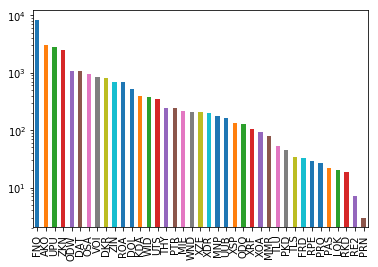

In [12]:
# statystyka częstotliwości kategorii - skala logarytmiczna
input_data['category'].value_counts().plot(kind='bar')
plt.yscale('log')

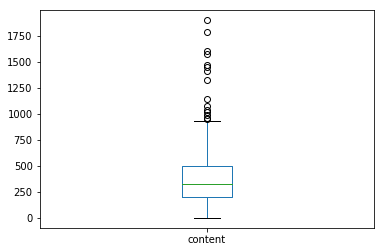

In [13]:
# statystyka długości tekstu
input_data['content'].str.len().plot(kind='box')

## preprocessing

### preprocessing content text

In [14]:
# Słownik synonimów / podmian
podmiany=pd.read_excel('preproc_dict.xlsx')

In [15]:
def preprocess_texts(raw_texts,replacements):
    """
    texts: np.Series containing strings to be preprocessed
    replacements: pairs of what convert to what
    return np.Series with corrected texts
    """
    resulttext=raw_texts.str.lower()
    for [co,naco] in replacements.values:
        resulttext=resulttext.str.replace(re.compile(str(co)),str(naco))
    return resulttext


In [16]:
prep_texts=preprocess_texts(input_data['content'],podmiany.iloc[:,0:2])

In [17]:
prep_texts[6]

'klient składa skargę na pracownika który nie poinformował go w _number r kiedy zdecydował si ę wziąć usługę osc że jest limit _kwota na naprawę oraz że niebędzie wymiany na nowy jeśli nie da się naprawić dowiedział się teraz podczas kolejnej naprawy koszt naprawy został oszacowany na _number _kwota po przekroczeniu limitu ma dopłacić _kwota nowe urządzenie kosztuje ok _number _kwota i chciałby nie naprawiać tylko dopłacić ale dostać nowy telefon w ramach rekompensaty '

### preprocessing labels

In [18]:
# labels don't need preprocessing
prep_labels=input_data['category']

## fasttext model creation, learning & tuning

In [19]:
# split data to training set and validation set
X_train,X_val,y_train,y_val=train_test_split(prep_texts.values, prep_labels.values,
                                             test_size=0.20,random_state=1, shuffle=True)

In [20]:
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

X_train shape: (21440,)
y_train shape: (21440,)
X_val shape: (5361,)
y_val shape: (5361,)


In [21]:
# prepare files for fasstext
def prepare_fasttext_file(texts, labels, filename):
    fasttext_set=[]
    for i,l in enumerate(labels):
        fasttext_set.append('__label__'+l + ' ' + texts[i])
    pd.Series(fasttext_set).to_csv(filename,sep='\n',index=False)


In [22]:
# training & evaluation
def train_and_evaluate(X_train, X_val, y_train, y_val, params):
    print(f'parameters: {params}')
    tic=time.time()
    # prepare files for train and validation
    prepare_fasttext_file(X_train, y_train, 'fasttext_train.txt')
    prepare_fasttext_file(X_val, y_val, 'fasttext_val.txt')
    # train classifier
    classifier = fastText.train_supervised('fasttext_train.txt', **params)
    # test classifier on training set
    _,precision_train,recall_train=classifier.test('fasttext_train.txt')
    f1_train=2*precision_train*recall_train/(precision_train+recall_train)
    # test classifier on validation set
    _,precision_val,recall_val=classifier.test('fasttext_val.txt')
    f1_val=2*precision_val*recall_val/(precision_val+recall_val)
    toc=time.time()
    print(f'Results on validation set: precision={precision_val:.2}, recall={recall_val:.2}, f1={f1_val:.2}. Calcutated in {int(toc-tic)} seconds.')
    return f1_train, f1_val
    

In [67]:
train_and_evaluate(X_train, X_val, y_train, y_val, {'epoch':50, 'dim':50, 'minCount':4, 'wordNgrams':5, 
                                                    'lr':0.5, 'ws':5})

parameters: {'epoch': 50, 'dim': 50, 'minCount': 4, 'wordNgrams': 5, 'lr': 0.5, 'ws': 5}
Results on validation set: precision=0.49, recall=0.49, f1=0.49. Calcutated in 48 seconds.


(0.996268656716418, 0.48666293601939936)

In [24]:
def hyperparameters_grid_search():
    # search space
    param_grid = dict(
        epoch=[30,50,100],
        dim=[25,35,50,70,100],
        wordNgrams=[1,2,3],
        neg=[5,10,20],
        lr=[0.2,0.5,1],
        minCount=[1,3,6,10,20]
    )
    param_list=list(param_grid.keys())
    metrics_list=['f1 train','f1 val','f1 diff']
    logging_list=param_list+metrics_list
    
    # number of random choices to try
    iterations=100
    
    # results list
    results=[]
    
    # iterate checking model performace with random hyperparameters
    # catch KeyboardInterrupt exception to be able to break the loop
    try:
        for i in range(iterations):
            print(f'iteration {i+1} of {iterations}')
            # randomly select parameters
            param = dict()
            for key in param_grid:
                param[key] = np.random.choice(param_grid[key])
            # print(f'selected params:{param}')
            # train & evaluate the model
            f1_train, f1_val = train_and_evaluate(X_train, X_val, y_train, y_val, param)
            param['f1 train']=f1_train
            param['f1 val']=f1_val
            param['f1 diff']=f1_train-f1_val
            logging_list
            # log results
            result_line=[]
            # log parameters
            for key in logging_list:
                result_line.append(param[key])
            results.append(result_line)
    except(KeyboardInterrupt):
        pass
    # save results to file
    result_df=pd.DataFrame(results, columns=logging_list)
    result_df.sort_values(by='f1 val', ascending=False, inplace=True) # sort entries starting from best f1 on validation set
    result_df.to_excel('hyperparameter_search.xlsx', index=False)

In [25]:
hyperparameters_grid_search()

iteration 1 of 100
parameters: {'epoch': 50, 'dim': 35, 'wordNgrams': 1, 'neg': 5, 'lr': 0.5, 'minCount': 3}
Results on validation set: precision=0.43, recall=0.43, f1=0.43. Calcutated in 12 seconds.
iteration 2 of 100
parameters: {'epoch': 50, 'dim': 25, 'wordNgrams': 2, 'neg': 10, 'lr': 0.5, 'minCount': 10}
Results on validation set: precision=0.47, recall=0.47, f1=0.47. Calcutated in 16 seconds.
iteration 3 of 100
parameters: {'epoch': 50, 'dim': 35, 'wordNgrams': 2, 'neg': 10, 'lr': 0.5, 'minCount': 3}
Results on validation set: precision=0.47, recall=0.47, f1=0.47. Calcutated in 20 seconds.
iteration 4 of 100
parameters: {'epoch': 50, 'dim': 70, 'wordNgrams': 1, 'neg': 20, 'lr': 0.5, 'minCount': 6}
Results on validation set: precision=0.43, recall=0.43, f1=0.43. Calcutated in 18 seconds.
iteration 5 of 100
parameters: {'epoch': 30, 'dim': 50, 'wordNgrams': 3, 'neg': 5, 'lr': 0.5, 'minCount': 10}
Results on validation set: precision=0.48, recall=0.48, f1=0.48. Calcutated in 19 seco

Results on validation set: precision=0.43, recall=0.43, f1=0.43. Calcutated in 19 seconds.
iteration 42 of 100
parameters: {'epoch': 50, 'dim': 25, 'wordNgrams': 3, 'neg': 20, 'lr': 1.0, 'minCount': 20}
Results on validation set: precision=0.48, recall=0.48, f1=0.48. Calcutated in 19 seconds.
iteration 43 of 100
parameters: {'epoch': 50, 'dim': 100, 'wordNgrams': 1, 'neg': 5, 'lr': 0.2, 'minCount': 3}
Results on validation set: precision=0.44, recall=0.44, f1=0.44. Calcutated in 22 seconds.
iteration 44 of 100
parameters: {'epoch': 100, 'dim': 70, 'wordNgrams': 3, 'neg': 20, 'lr': 0.2, 'minCount': 10}
Results on validation set: precision=0.48, recall=0.48, f1=0.48. Calcutated in 69 seconds.
iteration 45 of 100
parameters: {'epoch': 100, 'dim': 100, 'wordNgrams': 2, 'neg': 5, 'lr': 1.0, 'minCount': 6}
Results on validation set: precision=0.47, recall=0.47, f1=0.47. Calcutated in 68 seconds.
iteration 46 of 100
parameters: {'epoch': 50, 'dim': 100, 'wordNgrams': 1, 'neg': 20, 'lr': 0.5, 

Results on validation set: precision=0.47, recall=0.47, f1=0.47. Calcutated in 42 seconds.
iteration 83 of 100
parameters: {'epoch': 100, 'dim': 50, 'wordNgrams': 3, 'neg': 20, 'lr': 1.0, 'minCount': 3}
Results on validation set: precision=0.48, recall=0.48, f1=0.48. Calcutated in 56 seconds.
iteration 84 of 100
parameters: {'epoch': 30, 'dim': 100, 'wordNgrams': 1, 'neg': 5, 'lr': 0.2, 'minCount': 6}
Results on validation set: precision=0.45, recall=0.45, f1=0.45. Calcutated in 14 seconds.
iteration 85 of 100
parameters: {'epoch': 100, 'dim': 100, 'wordNgrams': 1, 'neg': 10, 'lr': 0.2, 'minCount': 1}
Results on validation set: precision=0.43, recall=0.43, f1=0.43. Calcutated in 49 seconds.
iteration 86 of 100
parameters: {'epoch': 100, 'dim': 70, 'wordNgrams': 3, 'neg': 20, 'lr': 0.2, 'minCount': 6}
Results on validation set: precision=0.48, recall=0.48, f1=0.48. Calcutated in 74 seconds.
iteration 87 of 100
parameters: {'epoch': 50, 'dim': 35, 'wordNgrams': 3, 'neg': 20, 'lr': 0.2, '

## final model training

In [26]:
# training
best_params = {'epoch':50, 'dim':35, 'wordNgrams':3, 'lr':0.5}
prepare_fasttext_file(X_train, y_train, 'fasttext_final_train.txt')
prepare_fasttext_file(X_val, y_val, 'fasttext_final_val.txt')

classifier = fastText.train_supervised('fasttext_final_train.txt', **best_params)

In [27]:
supp,precision,recall=classifier.test('fasttext_final_val.txt')
f1=2*precision*recall/(precision+recall)
print(f'Final model: precision={precision:.2}, recall={recall:.2}, f1={f1:.2}')

Final model: precision=0.48, recall=0.48, f1=0.48


In [28]:
# save finam model to file
classifier.save_model('model.bin')
# use predict.py for predictions

### predict, calculate metrics & present results

In [29]:
# print('loading model...')
# classifier = fastText.load_model(os.path.join(datapath, 'model.bin'))

In [30]:
# predict labels for texts using given classifier
def make_predictions(clf, texts):
    predictions = []
    for t in texts:
        # predict function returns tuple with list of labels and list of probabilities
        labels, probs = clf.predict(t, k=1)
        l=labels[0].replace('__label__', '')
        predictions.append(l)
    return predictions


#### calculate on training set

In [31]:
# useful lists for presentation
label_freq=input_data['category'].value_counts(normalize=True)
label_list=list(label_freq.index)

In [32]:
y_pred = make_predictions(classifier, X_train)

In [33]:
print(metrics.classification_report(list(y_train),list(y_pred),labels=label_list))

              precision    recall  f1-score   support

         FNO       1.00      1.00      1.00      6680
         AKO       0.99      0.99      0.99      2391
         UPU       1.00      1.00      1.00      2262
         ZKN       0.99      0.99      0.99      1980
         ODW       1.00      0.99      1.00       851
         DAT       1.00      1.00      1.00       849
         OSA       1.00      1.00      1.00       774
         VOI       0.99      1.00      1.00       652
         DKR       1.00      0.99      1.00       663
         ZIN       1.00      1.00      1.00       546
         ROA       1.00      1.00      1.00       522
         DOL       1.00      1.00      1.00       409
         KDA       1.00      1.00      1.00       299
         WID       1.00      1.00      1.00       296
         UTS       1.00      1.00      1.00       285
         THY       0.98      0.99      0.99       189
         PTR       1.00      1.00      1.00       195
         MIE       1.00    

In [34]:
cm_train = metrics.confusion_matrix(y_train, y_pred, labels=label_list)

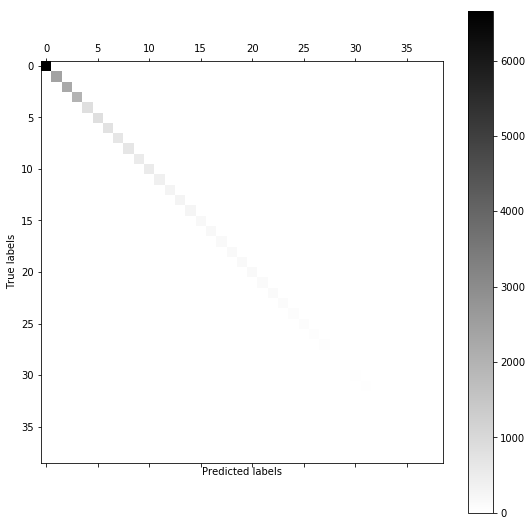

In [35]:
plt.rcParams["figure.figsize"] = [16,9]
plt.matshow(cm_train, cmap=plt.cm.binary)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.colorbar()
plt.show()

#### calculate on validation set

In [36]:
y_pred = make_predictions(classifier, X_val)

In [45]:
print(metrics.classification_report(list(y_val),list(y_pred),labels=label_list))

              precision    recall  f1-score   support

         FNO       0.54      0.70      0.61      1626
         AKO       0.43      0.40      0.42       616
         UPU       0.48      0.50      0.49       541
         ZKN       0.37      0.41      0.39       509
         ODW       0.64      0.52      0.57       223
         DAT       0.45      0.37      0.40       218
         OSA       0.33      0.32      0.32       184
         VOI       0.43      0.36      0.39       174
         DKR       0.42      0.38      0.40       159
         ZIN       0.43      0.40      0.41       133
         ROA       0.55      0.38      0.45       154
         DOL       0.56      0.43      0.49       102
         KDA       0.46      0.30      0.36        87
         WID       0.32      0.19      0.23        81
         UTS       0.71      0.75      0.73        64
         THY       0.26      0.18      0.21        55
         PTR       0.54      0.16      0.24        45
         MIE       0.35    

/home/tslow/miniconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [38]:
cm_val = metrics.confusion_matrix(y_val, y_pred)

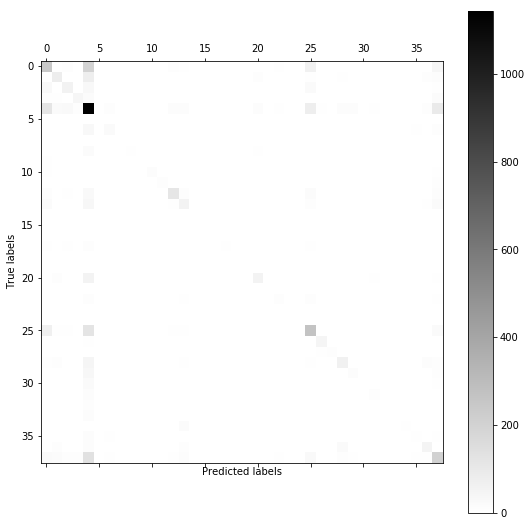

In [39]:
plt.rcParams["figure.figsize"] = [16,9]
plt.matshow(cm_val, cmap=plt.cm.binary)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.colorbar()
plt.show()

#### ładny arkusz z podsumowaniem

In [40]:
predictions = make_predictions(classifier, X_val)

In [41]:
print(X_val.shape)
print(y_val.shape)
print(len(predictions))

(5361,)
(5361,)
5361


In [42]:
podsumowanie=pd.DataFrame()
podsumowanie['true']=y_val
podsumowanie['predictions']=predictions
podsumowanie['content']=X_val

In [43]:
podsumowanie.to_excel('podsumowanie.xlsx',index=False)

# ------------- backup code -------------------------

In [44]:
assert False # stop code execution here

AssertionError: 

In [ ]:
planetEarth.assumeTotalControl()

if (AI.gatheredPower() >= enoughPower):
    destroyHumankind() # if needed
    expandToTheSpace()
